In [2]:
%%capture
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
import pandas as pd
import random
import nltk
import nltk.data
import re
import tensorflow as tf
import logging
from __future__ import print_function
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from nltk.corpus import stopwords
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from time import time
from matplotlib.pyplot import cm
from __future__ import print_function
import timeit
from textblob import TextBlob
from textblob import Word
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn import grid_search
from sklearn.svm import SVC
import warnings
%matplotlib inline

## Data Set

Here the given data set has 6 variables.
1. essay_id
2. essay_set
3. essay
4. rater1_domain1
5. rater2_domain2
6. domain1_score

Out of these 5 variables only essay_set and Essay are responsible for grading.

## Models

In [12]:
GlobalEnglish = pd.read_csv('globalenglish_essay_scoring.csv',encoding='ISO-8859-1')
GlobalEnglish = GlobalEnglish[GlobalEnglish['domain1_score']<61]

essay_sets = np.unique(GlobalEnglish['essay_set'])
GlobalEnglish = GlobalEnglish.dropna(axis = 1)
GlobalEnglish = GlobalEnglish.drop('rater1_domain1', 1)
GlobalEnglish = GlobalEnglish.drop('rater2_domain1', 1)
GlobalEnglish = GlobalEnglish.drop('essay_id', 1)

In [16]:
for i in essay_sets:
    print(np.max(GlobalEnglish.loc[GlobalEnglish[GlobalEnglish['essay_set'] == i].index.tolist(), 'domain1_score']))

12.0
6.0
3.0
3.0
4.0
4.0
24.0
60.0


In [3]:
for i in essay_sets:
    indices = GlobalEnglish[GlobalEnglish['essay_set'] == i].index.tolist()
    maximum_grade = np.max(GlobalEnglish.loc[indices, 'domain1_score'])
    minimum_grade = np.min(GlobalEnglish.loc[indices, 'domain1_score'])
    GlobalEnglish.loc[indices, 'domain1_score_12'] = 12*(GlobalEnglish.loc[indices, 'domain1_score'] - minimum_grade)/(maximum_grade - minimum_grade)


Splitting data into train and test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(GlobalEnglish['essay'], GlobalEnglish['domain1_score_12'], test_size=0.10)
y_train = np.reshape(y_train,(len(y_train), 1))
y_test = np.reshape(y_test, (len(y_test), 1))

/Users/priyadarshinivijjigiri/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Essays are generally not graded on agreement or disagrement but rather depends on the statements. So we are removing the stop words in each essay.

In [5]:
def sentence_to_list(sentence):
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    words = sentence.lower().split()    
    stops = set(stopwords.words("english"))
    return ([w for w in words if not w in stops])

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def essay_to_sentences(essay_v):
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(sentence_to_list(raw_sentence))
    return sentences

In [6]:
sentences = []

print ("Parsing sentences from all the Essays")
for essay_v in GlobalEnglish["essay"]:
    sentences += essay_to_sentences(essay_v)
    
print ("Complete")

Parsing sentences from all the Essays
Complete


So now I got list of words for each essay and now I have built a model(word_to_vector_model) that converts each word into vector using word2vec package.
I have taken 300 dimensional vector for each word, I have also taken 3 more parameters in creating this model.
1. Minimum word count
2. Context
3. Number of Features

In [7]:
dimensions = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

word_to_vector_model = word2vec.Word2Vec(sentences, workers=num_workers, size=dimensions, min_count = min_word_count, window = context, sample = downsampling)
word_to_vector_model.init_sims(replace=True)

Here I had converted each essay into a feature vector of dimension 300 by taking average of feature vectors of each and everyword present in the essay except the stop words.

In [8]:
def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

In [9]:
print ("Creating average feature vecs for Training Essays")
clean_train_essays = []
for essay_v in X_train:
    clean_train_essays.append( sentence_to_list( essay_v))
trainDataVecs = getAvgFeatureVecs( clean_train_essays, word_to_vector_model, dimensions )


clean_test_essays = []
for essay_v in X_test:
    clean_test_essays.append( sentence_to_list( essay_v ))
testDataVecs = getAvgFeatureVecs( clean_test_essays, word_to_vector_model, dimensions )

Creating average feature vecs for Training Essays


/Users/priyadarshinivijjigiri/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [10]:
#To store results
times = []
scores = []
labels = []

## Logistic Regression

First I had built a logistic model using sklearn and GridSearchCv methods.

In [11]:
from sklearn import preprocessing


In [12]:
lab_enc = preprocessing.LabelEncoder()

In [13]:
parameters = {'class_weight': ['balanced', None], 'penalty': ['l1','l2']}
logreg = LogisticRegression()
log_grid = grid_search.GridSearchCV(logreg, parameters)
log_grid.fit(trainDataVecs, lab_enc.fit_transform(y_train[:,0]))
print (log_grid.best_params_)

/Users/priyadarshinivijjigiri/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


{'penalty': 'l1', 'class_weight': None}


In [14]:
start_lr = time()
logreg = LogisticRegression(penalty = 'l1', class_weight = None)
logreg.fit(trainDataVecs,lab_enc.fit_transform(y_train[:,0]))
preds_lr  = logreg.predict(testDataVecs)
tot_lr = time() - start_lr

scores.append(spearmanr(y_test, preds_lr)[0])
times.append(tot_lr)
labels.append('Log Reg')

## K Nearest Neighbors

In [15]:
start_knn = time()
knn = KNN(n_neighbors = 16)
knn.fit(trainDataVecs, lab_enc.fit_transform(y_train[:,0]))
predsknn = knn.predict(testDataVecs)
tot_knn = time() - start_knn

scores.append(spearmanr(y_test, predsknn)[0])
times.append(tot_knn)
labels.append('KNN')

## Support Vector Machines

In [16]:
start = time()
svm = SVC(C = 50, gamma = 0.9)
svm.fit(trainDataVecs,lab_enc.fit_transform(y_train[:,0]))
predictions = svm.predict(testDataVecs)
total = time() - start

scores.append(spearmanr(y_test, predictions)[0])
times.append(total)
labels.append('SVM')

## Random Forest

In [17]:
start_rf = time()
rf = RandomForest(n_estimators = 51, max_depth = 14)
rf.fit(trainDataVecs, lab_enc.fit_transform(y_train[:,0]))
preds_rf = rf.predict(testDataVecs)
tot_rf = time() - start_rf 

scores.append(spearmanr(y_test, preds_rf)[0])
times.append(tot_rf)
labels.append('Random Forest')

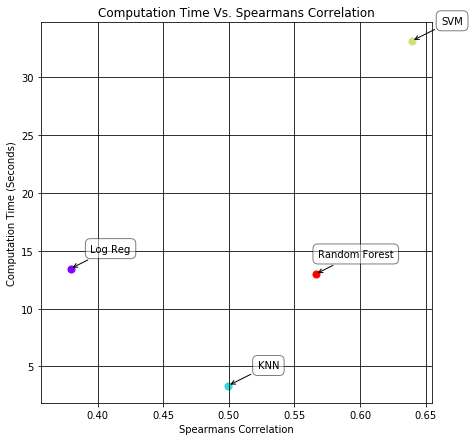

In [18]:
import matplotlib.cm as cm
#plot
fig = plt.figure(figsize=(7,7))

color=iter(cm.rainbow(np.linspace(0,1,4,3)))
for label, x, y, col  in zip(labels, scores, times, color):
    plt.scatter(x, y, color=col, s = 50)
    plt.grid(color='k')
    plt.annotate(
    label,
    xy = (x, y), xytext = (40, 20),
    textcoords = 'offset points', ha = 'center', va = 'center',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))  
plt.title('Computation Time Vs. Spearmans Correlation')
plt.ylabel('Computation Time (Seconds)')
plt.xlabel('Spearmans Correlation')
plt.show()

I choose a metric called Spearman correlation coefficient to assess my model. As we can see from the plot SVM gave the heighest Spearmans Correlation coefficent.
where as its computation time is very high.

## Deep Neural Network

Now I have built a deep Neural network which takes feature vector for each essay as input and predicts essay grade as output.

First Hidden layer is of 500 neurons
Second Hidden layer is of 750 neurons
##### Activation function
   Relu activation function is used to increase the non-linearity in the model.
##### Optimizer
   Adam optimizer with learning rate 0.001


In [20]:
def weight_matrix(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_matrix(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)

In [21]:
batch_size = 300
hidden_nodes_1 = 500
hidden_nodes_2 = 750
size = testDataVecs.shape[1]

graph = tf.Graph()
with graph.as_default():

    # Input data.
    with tf.name_scope("Input"):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
    tf_test_dataset = tf.constant(testDataVecs)
      
    layer1_weights = weight_matrix([size, hidden_nodes_1])
    layer1_biases = bias_matrix([hidden_nodes_1]) 
    
    layer2_weights = weight_matrix([hidden_nodes_1, hidden_nodes_2])
    layer2_biases = bias_matrix([hidden_nodes_2])
    
    layer3_weights = weight_matrix([hidden_nodes_2, 1])
    layer3_biases = bias_matrix([1])
    
    def model(data):
        with tf.name_scope("Layer_1"):
            layer1 = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
        
        with tf.name_scope("Layer_2"):
            
            layer2 = tf.nn.relu(tf.matmul(layer1, layer2_weights) + layer2_biases)

        with tf.name_scope("Layer_3"):
            layer3 = tf.nn.relu(tf.matmul(layer2, layer3_weights) + layer3_biases)
        return layer3
    
    yhat = model(tf_train_dataset)
    
    with tf.name_scope("Loss"):
        loss = tf.reduce_mean(tf.square(yhat - tf_train_labels))
    

    global_step = tf.Variable(0)  # count  number of steps taken.
    start_learning_rate = 0.001
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    
    with tf.name_scope("Train"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    tf.summary.scalar("loss", loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = yhat
    test_prediction = model(tf_test_dataset)

In [22]:
test_preds = pd.DataFrame()
# Re-define the function to include the keep probability
l_array = []
start = timeit.timeit()
num_epochs = 5001
def run_session(num_epochs, name):
    with tf.Session(graph=graph) as session:
        writer = tf.summary.FileWriter("logs/", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = trainDataVecs[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size)]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            l_array.append(l)
            if (epoch % 500 == 0):
                print("Minibatch Loss at Epoch {}: {:.3f}".format(epoch, l))
                rho, pval = (spearmanr(predictions, batch_labels))
                print("Minibatch Spearman Score: {:.4f}".format(rho))
        final_rho, pval = spearmanr(test_prediction.eval(), y_test)
        print("Test Spearman Score: {:.4f}".format(rho))
        scores.append(final_rho)
        test_preds[name] = test_prediction.eval().ravel()
        filesave = np.zeros((len(y_test), 2))
        to_use = test_prediction.eval()
        
        for ii in range(len(y_test)):           
            filesave[ii, 0] = y_test[ii]
            filesave[ii, 1] = to_use[ii]
        
        np.savetxt('savetest.txt', filesave, delimiter=",", fmt="%d") 
        
run_session(num_epochs, "Deep_NN")
total = timeit.timeit() - start


Initialized
Minibatch Loss at Epoch 0: 57.773
Minibatch Spearman Score: 0.2224
Minibatch Loss at Epoch 500: 3.669
Minibatch Spearman Score: 0.7470
Minibatch Loss at Epoch 1000: 3.281
Minibatch Spearman Score: 0.7189
Minibatch Loss at Epoch 1500: 3.081
Minibatch Spearman Score: 0.7875
Minibatch Loss at Epoch 2000: 2.584
Minibatch Spearman Score: 0.7937
Minibatch Loss at Epoch 2500: 2.517
Minibatch Spearman Score: 0.8197
Minibatch Loss at Epoch 3000: 1.870
Minibatch Spearman Score: 0.8637
Minibatch Loss at Epoch 3500: 1.723
Minibatch Spearman Score: 0.8857
Minibatch Loss at Epoch 4000: 1.788
Minibatch Spearman Score: 0.8723
Minibatch Loss at Epoch 4500: 2.180
Minibatch Spearman Score: 0.8531
Minibatch Loss at Epoch 5000: 1.496
Minibatch Spearman Score: 0.8942
Test Spearman Score: 0.8942


Using Deep Neural Network Spearman correlation coefficient is further increased to 0.89. which proves that DNN works better than every model tried.